# Introduction

This notebook demonstrated that Variational Auto-Encoders can learn, infer and extract useful features from input data. As input 
data we feed a convolution encoder and decoder with a combination of two patterns, one in the upper half and the other in the lower half of the input images. All data is build of pairwise combinations of 36 single patterns.<br>
We devide the set of all pair combinations into two sets of equal side, one is used for training batches and the raiming pairs are used as test batches. We train the model with the training batches and then evaluate the performance on the set of test batches. The model has seen all patterns in the test batch but **NOT** their pairwise combinations. Hence, good performance for the test batch can only be achieved if the model can infer or learn that all input images are composed of two patterns, in the upper and lower half respectively. <br>
The result of this experiment suggest that the VAE utilised is more than merely a memory unit as it can accurately reconstruct combinations of patterns it was not trained for. 

# Get pattern

In [1]:
from PIL import Image
import torch
import numpy
img = Image.open("./data/images/Retro-Patterns-2--Arvin61r58_s.png")
def PIL2array(img):
    return numpy.array(img.getdata(),
                    numpy.uint8).reshape(img.size[1], img.size[0], 3)
im=PIL2array(img)

## Plot all patterns

Here we plot all the 36 original patterns

<IPython.core.display.Javascript object>


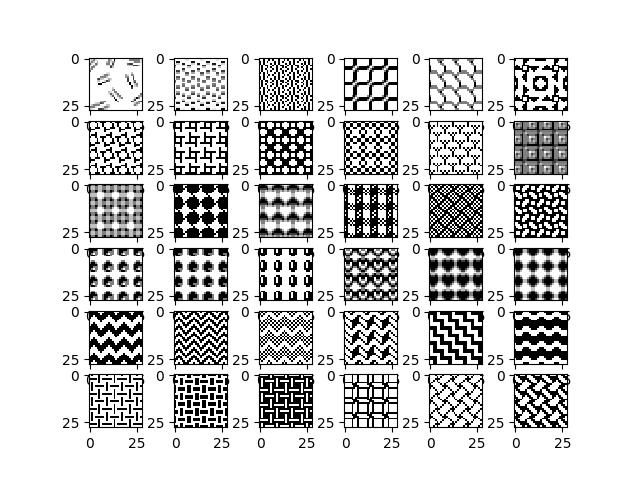

In [2]:
import matplotlib.pyplot as plt
import random
%matplotlib notebook

fig, axs = plt.subplots(6, 6)

patterns = []

for i,j in [(i,j) for i in range(6) for j in range(6)]:

    x_i = random.randint(0, 5)
    y_i = random.randint(0, 5)
    
    xx_i = 32 * i + 6 * ( i + 1 )
    yy_i = 32 * j + 6 * ( j + 1 )
    
    pattern = im[xx_i+2:xx_i+32-2,yy_i+2:yy_i+32-2,1]/255.
    patterns.append(pattern)
    
    axs[i, j].imshow(pattern, cmap="gray")


# Make batches

Now we construct the batches, which are combinations of the single patterns acquired above. The patterns are combined such that one pattern fills the upper half of the image and the other pattern the lower half.

In [3]:
from random import shuffle
import math
mixed = []
for idx, pattern1 in enumerate(patterns):
    for jdx, pattern2 in enumerate(patterns):
        if idx==jdx:
            continue
        pattern = pattern1.copy()
        pattern[0:15, :] = pattern2[0:15, :]
        mixed.append(pattern)

shuffle(mixed)
training = mixed[0:int(1260/2)]
test = mixed[int(1260/2):-1]
training_batches = []
test_batches = []
training_batches.append(torch.stack(torch.FloatTensor(patterns)).unsqueeze(1))
for i in range(math.ceil(len(training)/32)):
    training_batches.append(torch.stack(torch.FloatTensor(training[i*32:i*32+32])).unsqueeze(1))
test_batches.append(torch.stack(torch.FloatTensor(patterns)).unsqueeze(1))
for i in range(math.ceil(len(test)/32)):
    test_batches.append(torch.stack(torch.FloatTensor(test[i*32:i*32+32])).unsqueeze(1))

## Plot batches

Now that we have the batches we can plot one training batch and see how the pairwise combinations of patterns look.

<IPython.core.display.Javascript object>


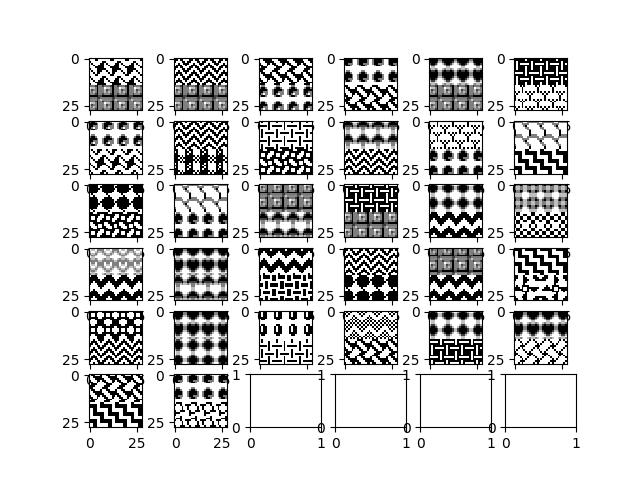

In [4]:
import matplotlib.pyplot as plt
import random
%matplotlib notebook
_range = [(i,j) for i in range(6) for j in range(6)]
fig, axs = plt.subplots(6, 6)

for idx, (i,j) in enumerate(_range):
    if idx>31:
        continue
    pattern = training_batches[2][idx]
    
    axs[i, j].imshow(pattern[0], cmap="gray")

# Get and train AutoEncoder

For the moment being we only use the dimension of the latent space as hyperparameters. The choose values of 2,4,6,8 and 10. Obviously
a 2 dimensions latent space seems to be a bit over-ambitious while 10 might be more than really needed. <br>
**Technical Note:** all VAE run in the background and cuda is not used in this experiment. Depending on the number of CPU cores available it might be more feasible to run one model at a time. VAEs can be stoped with vae.stop() and resumed with vae.restart().

In [5]:
import codes.VAE as VAE
import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

vaes = []
for i in [2,4,6,8,10]:
    vae = VAE.VariationalAutoEncoder(i, 0, convolutional = True)
    vae.set_train_loader(training_batches, test_batches)
    vaes.append((i, vae))
    #vae.start()

## Show results of the training and tests

We plot the losses of the trained batches as well as the test batches for all values of n_latent_units (dimension of latent space).
The outcome suggest that a 6 dimensional latent space is sufficient to not only train the model effectively but also to reconstruct
pairwise combinations of patterns it did not see before.

In [ ]:
import matplotlib.pyplot as plt
import numpy
%matplotlib notebook

a_2 = numpy.array(vaes[0][1].get_progress())
a_4 = numpy.array(vaes[1][1].get_progress())
a_6 = numpy.array(vaes[2][1].get_progress())
a_8 = numpy.array(vaes[3][1].get_progress())
a_10 = numpy.array(vaes[4][1].get_progress())
plt.ylim(0, 200)
plt.xlim(0, 1000)
plt.plot(a_2[:,0],a_2[:,1],'b',a_2[:,0],a_2[:,2],'b--')
plt.plot(a_4[:,0],a_4[:,1],'g',a_4[:,0],a_4[:,2],'g--')
plt.plot(a_6[:,0],a_6[:,1],'r',a_6[:,0],a_6[:,2],'r--')
plt.plot(a_8[:,0],a_8[:,1],'yellow')
plt.plot(a_8[:,0],a_8[:,2],'yellow',linestyle='--')
plt.plot(a_10[:,0],a_10[:,1],'orange')
plt.plot(a_10[:,0],a_10[:,2],'orange',linestyle='--')

## Visual verification
We can also check visually how well the model reconstructs pairwise combinations that were not part of the training set

<IPython.core.display.Javascript object>


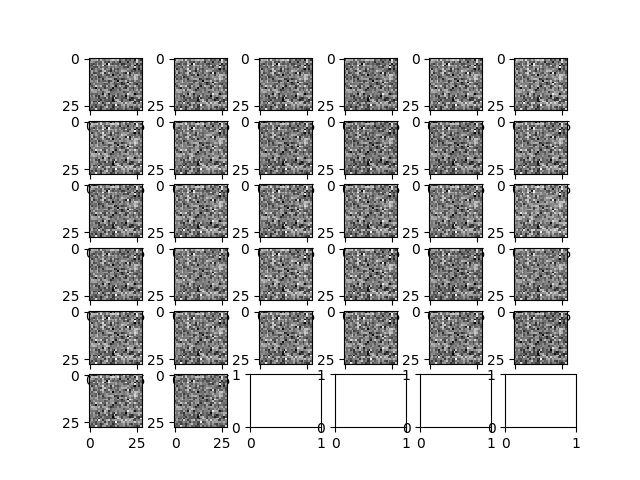

In [6]:
import matplotlib.pyplot as plt
import random
%matplotlib notebook
_range = [(i,j) for i in range(6) for j in range(6)]
fig, axs = plt.subplots(6, 6)

for idx, (i,j) in enumerate(_range):
    if idx>31:
        break
    pattern = test_batches[2][idx]
    
    axs[i, j].imshow(vaes[4][1](Variable(pattern.unsqueeze(0)))[0,0,:,:].data, cmap="gray")

Comparing it to the original input....

<IPython.core.display.Javascript object>


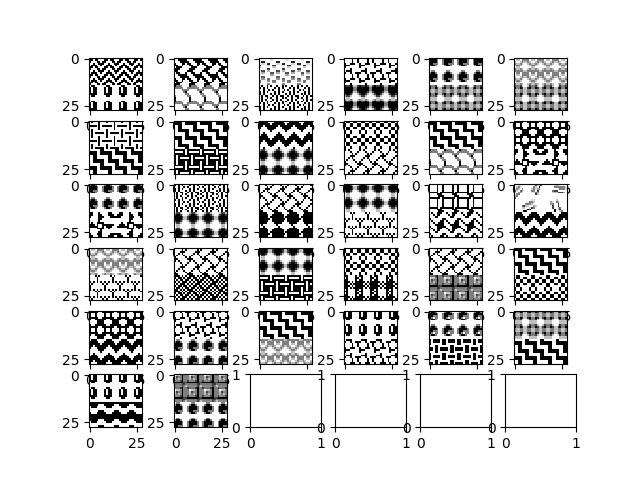

In [296]:
import matplotlib.pyplot as plt
import random
%matplotlib notebook
_range = [(i,j) for i in range(6) for j in range(6)]
fig, axs = plt.subplots(6, 6)

for idx, (i,j) in enumerate(_range):
    if idx>31:
        break
    pattern = test_batches[2][idx]
    
    axs[i, j].imshow((Variable(pattern.unsqueeze(0)))[0,0,:,:].data, cmap="gray")

# Conclusion

The model is obviously highly capable of reproducing combinations of patterns it has not been trained with. This implies, first that these unknown combinations are part of the solutions space of the model and hence demonstrates that the VAE was able to conceptionalise the given task.